## Load Libraries

In [1]:
#import libraries
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
import h5py
from keras.models import load_model
from keras import models

## Load BadNet

In [2]:
# Clone Respository
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

fatal: destination path 'CSAW-HackML-2020' already exists and is not an empty directory.


In [3]:
# Load BadNet
model_path = '/content/CSAW-HackML-2020/lab3/models/bd_net.h5'
BadNet = load_model(model_path)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
BadNet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [4]:
BadNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [5]:
!python /content/CSAW-HackML-2020/lab3/eval.py /content/drive/MyDrive/valid.h5 /content/drive/MyDrive/bd_valid.h5 /content/CSAW-HackML-2020/lab3/models/bd_net.h5

2021-12-17 04:39:32.365279: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


## Model Pruning

In [6]:
# Load validation dataset
#data_path = '/content/CSAW-HackML-2020/lab3/data/valid.h5'
clean_valid_data_path = '/content/drive/MyDrive/valid.h5'

file_name = h5py.File(clean_valid_data_path, 'r')
#file_name.keys()
clean_valid_data_value = np.array(file_name['data'])
#data_value.shape
clean_valid_data_value = clean_valid_data_value.transpose((0,2,3,1))
clean_valid_data_label = np.array(file_name['label'])
#data_label.shape

clean_test_data_path = '/content/drive/MyDrive/test.h5'

file_name = h5py.File(clean_test_data_path, 'r')
#file_name.keys()
clean_test_data_value = np.array(file_name['data'])
#data_value.shape
clean_test_data_value = clean_test_data_value.transpose((0,2,3,1))
clean_test_data_label = np.array(file_name['label'])
#data_label.shape

backdoor_test_data_path = '/content/drive/MyDrive/bd_valid.h5'

file_name = h5py.File(backdoor_test_data_path, 'r')
#file_name.keys()
backdoor_test_data_value = np.array(file_name['data'])
#data_value.shape
backdoor_test_data_value = backdoor_test_data_value.transpose((0,2,3,1))
backdoor_test_data_label = np.array(file_name['label'])
#data_label.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


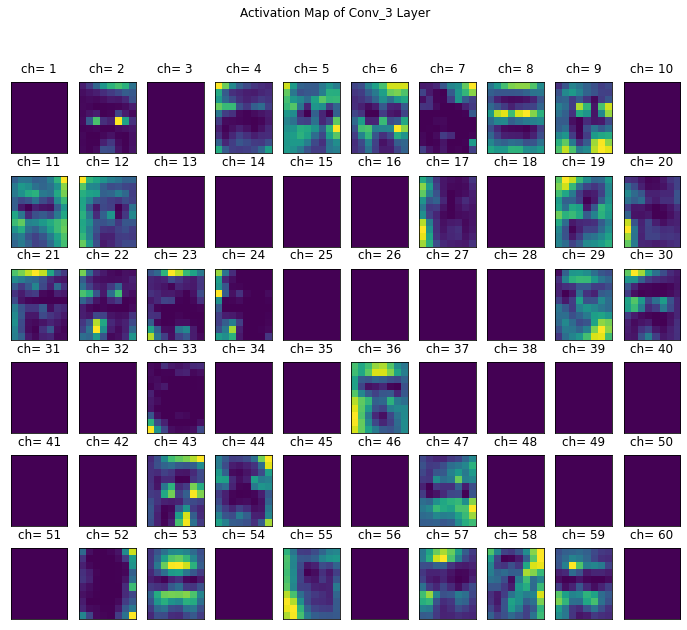

In [7]:
# Create RepairedNet
RepairedNet = load_model(model_path)
RepairedNet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Pruning and evalauating accuracy of pruned model ### Just a format for now
[base_loss, base_accuracy] = BadNet.evaluate(clean_valid_data_value, clean_valid_data_label, verbose=0)
threshold_accuracy = base_accuracy
repaired_accuracy = base_accuracy

activation_model = models.Model(inputs=RepairedNet.input, outputs=RepairedNet.layers[5].output)
pruning_layer_activations = activation_model.predict(clean_valid_data_value) 

number_images = pruning_layer_activations.shape[0]
number_rows = pruning_layer_activations.shape[1]
number_columns = pruning_layer_activations.shape[2]
number_channels = pruning_layer_activations.shape[3]

total_activation_per_channel = np.zeros([number_rows, number_columns, number_channels])
for i in range(number_channels):
  for j in range(number_images):
    total_activation_per_channel[:,:,i] += pruning_layer_activations[j,:,:,i]
average_activation_per_channel = total_activation_per_channel/number_images

average_activation_value = []
for i in range(number_channels):
  average_activation_value.append(np.sum(average_activation_per_channel[:,:,i])/(number_rows*number_columns))
sorted_activation_value = average_activation_value[:]
sorted_activation_value = list(set(sorted_activation_value))
sorted_activation_value.sort()

sort_index = 0
weights,biases = BadNet.layers[5].get_weights()

plt.figure(figsize=(12,10))
for i in range(6):
    for j in range(10):
        ax = plt.subplot2grid((6,10), (i,j))
        ax.matshow(average_activation_per_channel[:,:,i*10+j])
        ax.set_title('ch= '+str(i*10+j+1), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
plt.suptitle('Activation Map of Conv_3 Layer')
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

In [8]:
number_of_channels_pruned = []
clean_test_data_accuracy = []
clean_test_data_loss = []
attack_success_rate = []
attack_success_loss = []

In [14]:
# In this case, all the channels are pruned to obtain a graph of clean test data accuracy 
# and attack success rate as a fraction of pruned channels. Therefore, 0.96 in the 
# pruning_accuracy_tolerance below should be set to the desired decrease in clean test data accuracy, that is: 0.02, 0.04 or 0.10
pruning_accuracy_tolerance = 0.96
while repaired_accuracy >= base_accuracy - pruning_accuracy_tolerance:
  minumum_activation = sorted_activation_value[sort_index]
  pruned_channel_count = 0
  unpruned_channel_count = 0
  unpruned_channel_index = []
  for i in range(number_channels):
    if average_activation_value[i] <= minumum_activation:                
      pruned_channel_count += 1
    if average_activation_value[i] > minumum_activation:
      unpruned_channel_index.append(i)
      unpruned_channel_count += 1

  unpruned_weights = weights.transpose(3,2,1,0)[unpruned_channel_index]
  unpruned_weights = unpruned_weights.transpose(3,2,1,0)
  unpruned_biases = biases[unpruned_channel_index]
  unpruned_weights.shape, unpruned_biases.shape

  new_weights = np.zeros((3,3,40,60))
  new_biases = np.zeros(60)
  for j in range((unpruned_channel_count)):
    i = unpruned_channel_index[j]
    new_weights[:,:,:,i] = unpruned_weights[:,:,:,j]
    new_biases[i] = unpruned_biases[j]

  RepairedNet.layers[5].set_weights([new_weights, new_biases])
  [repaired_loss, repaired_accuracy] = RepairedNet.evaluate(clean_valid_data_value, clean_valid_data_label, verbose=2)
  [a, x] = RepairedNet.evaluate(clean_test_data_value, clean_test_data_label, verbose=0)
  [b, y] = RepairedNet.evaluate(backdoor_test_data_value, backdoor_test_data_label, verbose=0)

  number_of_channels_pruned.append(pruned_channel_count)
  clean_test_data_accuracy.append(x)
  attack_success_rate.append(y)

  #print(minumum_activation) 
  print('Number of pruned channel is:', pruned_channel_count)
  print('Number of unpruned channel is:', unpruned_channel_count)
  if sort_index < len(sorted_activation_value):
    sort_index += 1
  #print(sort_index)
print(repaired_accuracy)

0.01550186239182949


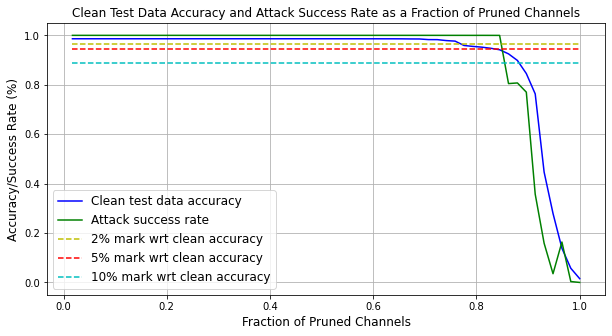

In [10]:
adjusted_number_of_channels_pruned = [1] + number_of_channels_pruned
adjusted_clean_test_data_accuracy = [clean_test_data_accuracy[0]] + clean_test_data_accuracy
adjusted_attack_success_rate = [attack_success_rate[0]] + attack_success_rate
scaled_adjusted_number_of_channels_pruned = [number/max(adjusted_number_of_channels_pruned) for number in adjusted_number_of_channels_pruned]

plt.figure(figsize=(10,5))
plt.title('Activation Map of Conv_3 Layer')
plt.plot(scaled_adjusted_number_of_channels_pruned, adjusted_clean_test_data_accuracy, 'b',)
plt.plot(scaled_adjusted_number_of_channels_pruned, adjusted_attack_success_rate, 'g',)
plt.plot(scaled_adjusted_number_of_channels_pruned, (adjusted_clean_test_data_accuracy[0] - 0.02)*np.ones(len(adjusted_attack_success_rate)), 'y--', linestyle='dashed')
plt.plot(scaled_adjusted_number_of_channels_pruned, (adjusted_clean_test_data_accuracy[0] - 0.04)*np.ones(len(adjusted_attack_success_rate)), 'r--', linestyle='dashed')
plt.plot(scaled_adjusted_number_of_channels_pruned, (adjusted_clean_test_data_accuracy[0] - 0.10)*np.ones(len(adjusted_attack_success_rate)), 'c--', linestyle='dashed')
plt.xlabel('Fraction of Pruned Channels', fontsize=12)
plt.ylabel('Accuracy/Success Rate (%)', fontsize=12)
plt.title('Clean Test Data Accuracy and Attack Success Rate as a Fraction of Pruned Channels' , fontsize=12)
plt.legend(['Clean test data accuracy', 'Attack success rate', '2% mark wrt clean accuracy', '5% mark wrt clean accuracy', '10% mark wrt clean accuracy'], fontsize=12)
plt.grid()
plt.show()

## Saving the Repaired Net

In [11]:
# The repaired model was saved as by uncommenting the following line of code
# where X was changed to 2, 4 and 10 for the 2%, 4% and 10% pruning cases, respectively. 

#RepairedNet_X.save('RepairedNet_X.h5')

## Creating GoodNet and Evaluating Pruning Performance

In [12]:
# I hvae loaded the following test dataset using my data directory.
backdoor_test_data_path = '/content/drive/MyDrive/bd_test.h5'

file_name = h5py.File(backdoor_test_data_path, 'r')
#file_name.keys()
backdoor_test_data_value = np.array(file_name['data'])
#backdoor_test_data_value.shape
backdoor_test_data_value = backdoor_test_data_value.transpose((0,2,3,1))
backdoor_test_data_label = np.array(file_name['label'])
#backdoor_test_data_label.shape

clean_test_data_path = '/content/drive/MyDrive/test.h5'

file_name = h5py.File(clean_test_data_path, 'r')
#file_name.keys()
clean_test_data_value = np.array(file_name['data'])
#backdoor_test_data_value.shape
clean_test_data_value = clean_test_data_value.transpose((0,2,3,1))
clean_test_data_label = np.array(file_name['label'])
#backdoor_test_data_label.shape

In [18]:
# Specify the index (i) of the dataset to evaluate
########################################################
i = 100 # A default index of 100 is used here
########################################################
bd_label_p = np.argmax(BadNet.predict(backdoor_test_data_value), axis=1)
cl_label_p = np.argmax(RepairedNet.predict(clean_test_data_value), axis=1)

if bd_label_p[i] == cl_label_p[i]:
  test_data_label = cl_label_p[i]
  print('\n The test image is a clean and its label is:', cl_label_p)
else:
  test_data_label = 1283
  print('\n The test image is poisoned and its label is outside of the class. Therefore, its label is outputed as:', 1283)


 The test image is poisoned and its label is outside of the class. Therefore, its label is outputed as: 1283
